In [46]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

print(tf.__version__)
print(keras.__version__)

2.1.0
2.2.4-tf


# Utilities

In [29]:
import os
root_logdir = os.path.join(os.curdir, "my_logs")
print(os.getcwd())

def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir() # e.g., './my_logs/run_2019_06_07-15_15_22'

/home/oonisim/home/repositories/git/oonisim/handson-ml2/workspace


# Data

In [30]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

In [31]:
type(X_train_full)

numpy.ndarray

In [32]:
X_valid, X_train = X_train_full[:5000] / 255.0, X_train_full[5000:] / 255.0
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.0

In [33]:
print(X_train.dtype)
print(X_train.shape)

float64
(55000, 28, 28)


In [34]:
class_names = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

In [35]:
class_names[y_train[0]]

'Coat'

# Model

In [36]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(len(class_names), activation="softmax"))

In [37]:
# First layter 784 × 300 connection weights, plus 300 bias terms, which adds up to 235,500 parameters
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 300)               235500    
_________________________________________________________________
dense_4 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_5 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


In [38]:
# Get the weidhts and biases in a layer
hidden1 = model.layers[1]
print(hidden1.name)

weights, biases = hidden1.get_weights()
weights

dense_3


array([[ 0.01283181, -0.04363849,  0.00420354, ...,  0.05277629,
        -0.02500245, -0.04896446],
       [ 0.05099496, -0.01970569,  0.07249585, ...,  0.06550682,
        -0.0275849 , -0.05232431],
       [ 0.05682044, -0.05970134,  0.01657232, ...,  0.00221235,
        -0.02660386, -0.02430792],
       ...,
       [-0.00677308, -0.07008056,  0.01469636, ...,  0.00321642,
        -0.0608648 , -0.04604502],
       [-0.01487913,  0.01606531,  0.00186215, ...,  0.05284923,
         0.03244198,  0.00373627],
       [-0.07167386, -0.05469703, -0.06296001, ...,  0.02835721,
        -0.01086953, -0.04861474]], dtype=float32)

In [39]:
# Attach computation logic to the model
model.compile(
    loss="sparse_categorical_crossentropy",   # Cross entropy loss for sparse categorical labels
    #optimizer="sgd",                          
    optimizer=keras.optimizers.SGD(lr=0.01),  # Use stochastic gradient descent
    metrics=["accuracy"]                      # Evaluate the model performance with accuracy.
)

### Callbacks

In [40]:
early_stopping_cb = keras.callbacks.EarlyStopping(
  patience=10,
  restore_best_weights=True
)
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

In [41]:
history = model.fit(
    X_train, 
    y_train, 
    epochs=30, 
    validation_data=(X_valid, y_valid),
    callbacks=[
        early_stopping_cb,
        tensorboard_cb
    ]
)

Train on 55000 samples, validate on 5000 samples
Epoch 1/30
55000/55000 [==============================] - 19s 351us/sample - loss: 0.7119 - accuracy: 0.7670 - val_loss: 0.5128 - val_accuracy: 0.8282
Epoch 2/30
55000/55000 [==============================] - 16s 295us/sample - loss: 0.4883 - accuracy: 0.8302 - val_loss: 0.4507 - val_accuracy: 0.8418
Epoch 3/30
55000/55000 [==============================] - 19s 338us/sample - loss: 0.4428 - accuracy: 0.8448 - val_loss: 0.4237 - val_accuracy: 0.8540
Epoch 4/30
55000/55000 [==============================] - 26s 482us/sample - loss: 0.4155 - accuracy: 0.8545 - val_loss: 0.4037 - val_accuracy: 0.8598
Epoch 5/30
55000/55000 [==============================] - 29s 528us/sample - loss: 0.3957 - accuracy: 0.8612 - val_loss: 0.4037 - val_accuracy: 0.8544
Epoch 6/30
55000/55000 [==============================] - 27s 486us/sample - loss: 0.3786 - accuracy: 0.8664 - val_loss: 0.3755 - val_accuracy: 0.8684
Epoch 7/30
55000/55000 [=====================

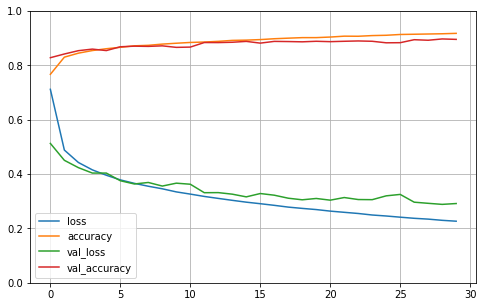

In [42]:
import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [43]:
model.evaluate(X_test, y_test)

10000/10000 [==============================] - 2s 228us/sample - loss: 0.3282 - accuracy: 0.8850


[0.32815694898366926, 0.885]

In [47]:
test_logdir = get_run_logdir()
writer = tf.summary.create_file_writer(test_logdir)
with writer.as_default():
    for step in range(1, 1000 + 1):
        tf.summary.scalar("my_scalar", np.sin(step / 10), step=step)
        data = (np.random.randn(100) + 2) * step / 100 # some random data
        tf.summary.histogram("my_hist", data, buckets=50, step=step)
        images = np.random.rand(2, 32, 32, 3) # random 32×32 RGB images
        tf.summary.image("my_images", images * step / 1000, step=step)
        texts = ["The step is " + str(step), "Its square is " + str(step**2)]
        tf.summary.text("my_text", texts, step=step)
        sine_wave = tf.math.sin(tf.range(12000) / 48000 * 2 * np.pi * step)
        audio = tf.reshape(tf.cast(sine_wave, tf.float32), [1, -1, 1])
        tf.summary.audio("my_audio", audio, sample_rate=48000, step=step)

In [44]:
%load_ext tensorboard
%tensorboard --logdir=./my_logs --port=6006

Reusing TensorBoard on port 6006 (pid 35986), started 1:37:25 ago. (Use '!kill 35986' to kill it.)